In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("owid-covid-data2.csv")

In [ ]:
df = pd.read_csv("owid-covid-data.csv")

In [ ]:
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92874,ZWE,Africa,Zimbabwe,2021-05-28,38918.0,64.0,36.286,1592.0,0.0,0.857,2618.461,4.306,2.441,107.112,0.000,0.058,1.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1833.0,546389.0,36.762,0.123,1727.0,0.116,0.021,47.6,tests performed,976796.0,656630.0,320166.0,23407.0,12695.0,6.57,4.42,2.15,854.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
92875,ZWE,Africa,Zimbabwe,2021-05-29,38933.0,15.0,36.286,1594.0,2.0,1.143,2619.471,1.009,2.441,107.247,0.135,0.077,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2032.0,548421.0,36.899,0.137,1790.0,0.120,0.020,49.3,tests performed,1002465.0,666786.0,335679.0,25669.0,14056.0,6.74,4.49,2.26,946.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
92876,ZWE,Africa,Zimbabwe,2021-05-30,38944.0,11.0,37.429,1594.0,0.0,1.143,2620.211,0.740,2.518,107.247,0.000,0.077,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1011973.0,670755.0,341218.0,9508.0,14420.0,6.81,4.51,2.30,970.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
92877,ZWE,Africa,Zimbabw

In [ ]:
df_india = df[df['location'].isin(["India"])] 
df_india

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
38393,IND,Asia,India,2020-01-30,1.0,1.0,NaN,NaN,NaN,NaN,0.001,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38394,IND,Asia,India,2020-01-31,1.0,0.0,NaN,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38395,IND,Asia,India,2020-02-01,1.0,0.0,NaN,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38396,IND,Asia,India,2020-02-02,2.0,1.0,NaN,NaN,NaN,NaN,0.001,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38397,IND,Asia,India,2020-02-03,3.0,1.0,NaN,NaN,NaN,NaN,0.002,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38877,IND,Asia,India,2021-05-28,27729247.0,173790.0,205708.143,322512.0,3617.0,3855.286,20093.593,125.934,149.063,233.704,2.621,2.794,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2070508.0,339039861.0,245.680,1.500,2088856.0,1.514,0.098,10.2,samples tested,203166802.0,160605562.0,42561240.0,1963636.0,1971730.0,14.72,11.64,3.08,1429.0,81.94,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38878,IND,Asia,India,2021-05-29,27894800.0,165553.0,194952.571,325972.0,3460.0,3815.143,20213.559,119.966,141.270,236.211,2.507,2.765,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2080048.0,341119909.0,247.188,1.507,2090822.0,1.515,0.093,10.7,samples tested,207088953.0,164158704.0,42930249.0,3922151.0,2320922.0,15.01,11.90,3.11,1682.0,81.94,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38879,IND,Asia,India,2021-05-30,28047534.0,152734.0,185012.429,329100.0,3128.0,3625.714,20324.235,110.676,134.067,238.478,2.267,2.627,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2063839.0,343183748.0,248.683,1.496,2082259.0,1.509,0.089,11.3,samples tested,208665123.

In [ ]:
df_india_filtered = df_india.filter(items=['date',
                                           'total_cases', 'new_cases',
                                           'total_deaths', 'new_deaths',
                                           'reproduction_rate', 'positive_rate', 'stringency_index',
                                           'new_tests', 'total_tests',
                                           'new_vaccinations', 'total_vaccinations',
                                           'people_vaccinated', 'people_fully_vaccinated'])

df_india_filtered = df_india_filtered.reset_index()
df_india_filtered = df_india_filtered.drop(['index'], axis=1)

df_india_filtered = df_india_filtered.drop(df_india_filtered.tail(2).index)
df_india_filtered["date"] = pd.to_datetime(df_india_filtered["date"])

df_india_filtered = df_india_filtered.ffill(axis=0)
df_india_filtered = df_india_filtered.fillna(0)

In [ ]:
# full data for India filtered and selected
df_india_filtered

,date,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,positive_rate,stringency_index,new_tests,total_tests,new_vaccinations,total_vaccinations,people_vaccinated,people_fully_vaccinated
0,2020-01-30,1.0,1.0,0.0,0.0,0.00,0.000,10.19,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-31,1.0,0.0,0.0,0.0,0.00,0.000,10.19,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-01,1.0,0.0,0.0,0.0,0.00,0.000,10.19,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-02,2.0,1.0,0.0,0.0,0.00,0.000,10.19,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-03,3.0,1.0,0.0,0.0,0.00,0.000,10.19,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,2021-05-26,27369093.0,211298.0,315235.0,3847.0,0.78,0.110,81.94,2217320.0,334811496.0,2918836.0,198425615.0,156189641.0,42235974.0
483,2021-05-27,27555457.0,186364.0,318895.0,3660.0,0.78,0.104,81.94,2157857.0,336969353.0,2777551.0,201203166.0,158783606.0,42419560.0
484,2021-05-28,27729247.0,173790.0,322512.0,3617.0,0.77,0.098,81.94,2070508.0,339039861.0,1963636.0,203166802.0,160605562.0,42561240.0
485,2021-05-29,27894800.0,165553.0,325972.0,3460.0,0.77,0.093,81.94,2080048.0,341119909.0,3922151.0,207088953.0,164158704.0,42930249.0


In [ ]:
df_india_filtered.dtypes

date                       datetime64[ns]
total_cases                       float64
new_cases                         float64
total_deaths                      float64
new_deaths                        float64
reproduction_rate                 float64
positive_rate                     float64
stringency_index                  float64
new_tests                         float64
total_tests                       float64
new_vaccinations                  float64
total_vaccinations                float64
people_vaccinated                 float64
people_fully_vaccinated           float64
dtype: object

In [ ]:
df_india_filtered.describe()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,positive_rate,stringency_index,new_tests,total_tests,new_vaccinations,total_vaccinations,people_vaccinated,people_fully_vaccinated
count,4.870000e+02,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,4.870000e+02,4.870000e+02,4.870000e+02,4.870000e+02,4.870000e+02,4.870000e+02
mean,6.683781e+06,57592.472279,91903.887064,675.770021,1.060267,0.060961,70.726489,7.051047e+05,1.043316e+08,4.420912e+05,2.111067e+07,1.736822e+07,3.742450e+06
std,6.765560e+06,88546.350427,80826.888068,983.250966,0.444600,0.050027,21.676790,5.596651e+05,1.044784e+08,9.603770e+05,5.031640e+07,4.074215e+07,9.788061e+06
min,1.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000,10.190000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.862180e+05,7530.500000,5296.500000,100.500000,0.900000,0.022000,61.570000,1.180085e+05,3.674313e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.225763e+06,24850.000000,97497.000000,355.000000,1.090000,0.046000,73.610000,7.592830e+05,7.311004e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.072659e+07,62626.000000,154078.500000,835.000000,1.265000,0.084000,85.650000,1.083502e+06,1.947099e+08,1.899715e+05,3.214040e+06,3.214040e+06,0.000000e+00
max,2.804753e+07,414188.000000,329100.000000,4529.000000,2.270000,0.227000,100.000000,2.217320e+06,3.431837e+08,4.265157e+06,2.086651e+08,1.655980e+08,4.306711e+07


In [ ]:
# df_india_filtered.to_csv('India_Filtered.csv')
# from google.colab import files
# files.download('India_Filtered.csv')

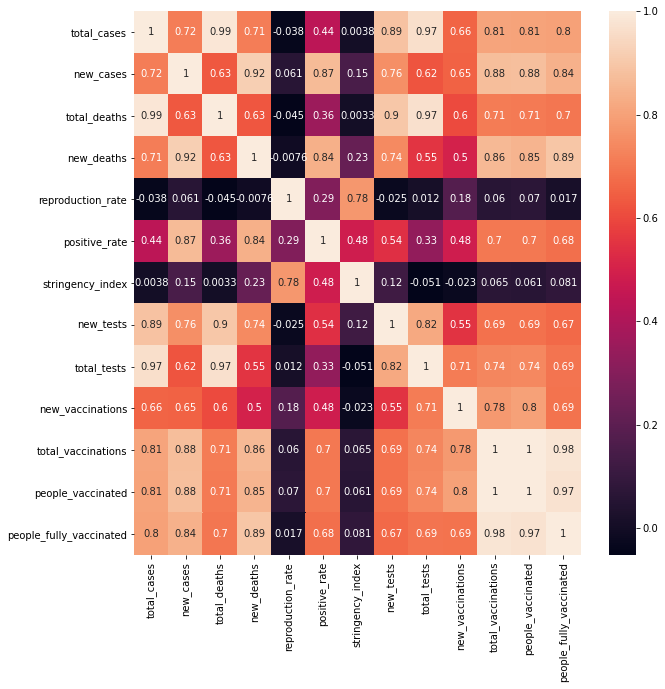

In [ ]:
plt.figure(figsize=(10,10))
df_india_filtered_corr = df_india_filtered.corr()
sns.heatmap(df_india_filtered_corr, annot=True)
plt.show()

Optimizing and selecting features for analysis

In [ ]:
df_dates = df_india_filtered.filter(items=['date'])
df_new_cases = df_india_filtered.filter(items=['new_cases'])
df_new_deaths = df_india_filtered.filter(items=['new_deaths'])

In [ ]:
df_dates.shape

(487, 1)

In [ ]:
corr=df_india_filtered.corr()
corr[["new_cases"]]

,new_cases
total_cases,0.716415
new_cases,1.000000
total_deaths,0.634068
new_deaths,0.919376
reproduction_rate,0.061243
positive_rate,0.867462
stringency_index,0.153089
new_tests,0.755443
total_tests,0.624481
new_vaccinations,0.652782


More data prep

In [ ]:
dataset_cases = df_india_filtered.filter(items=['new_cases', "new_deaths",
                                           'positive_rate',
                                          'new_tests', 
                                          'new_vaccinations',
                                          'people_vaccinated'])

cols = list(dataset_cases)[0:6]

print('Training set shape == {}'.format(dataset_cases.shape))
print('All Time Stamps == {}'.format(len(df_dates)))
print('Features Selected == {}'.format(cols))

Training set shape == (487, 6)
All Time Stamps == 487
Features Selected == ['new_cases', 'new_deaths', 'positive_rate', 'new_tests', 'new_vaccinations', 'people_vaccinated']


In [ ]:
dataset_cases

,new_cases,new_deaths,positive_rate,new_tests,new_vaccinations,people_vaccinated
0,1.0,0.0,0.000,0.0,0.0,0.0
1,0.0,0.0,0.000,0.0,0.0,0.0
2,0.0,0.0,0.000,0.0,0.0,0.0
3,1.0,0.0,0.000,0.0,0.0,0.0
4,1.0,0.0,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...
482,211298.0,3847.0,0.110,2217320.0,2918836.0,156189641.0
483,186364.0,3660.0,0.104,2157857.0,2777551.0,158783606.0
484,173790.0,3617.0,0.098,2070508.0,1963636.0,160605562.0
485,165553.0,3460.0,0.093,2080048.0,3922151.0,164158704.0


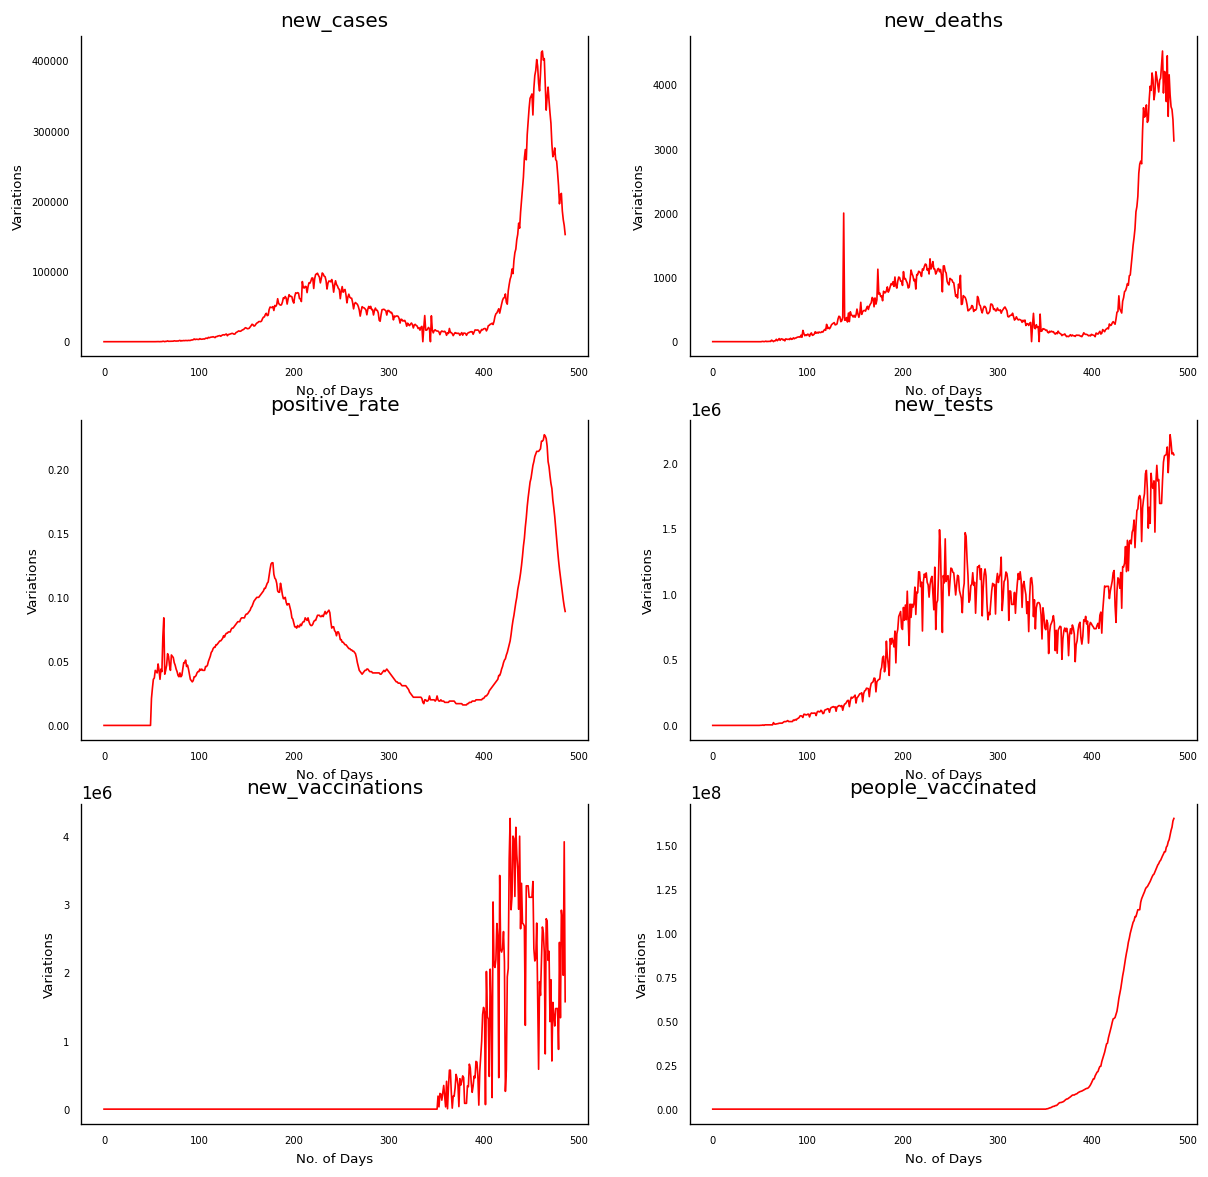

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    data = dataset_cases[dataset_cases.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset_cases.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xlabel('No. of Days', fontsize = 8)
    ax.set_ylabel('Variations', fontsize = 8)
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [ ]:
plt.savefig('plot.png')
from google.colab import files
files.download("plot.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

Granger’s Causality Test

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

  

In [ ]:
grangers_causation_matrix(dataset_cases, variables = dataset_cases.columns) 

,new_cases_x,new_deaths_x,positive_rate_x,new_tests_x,new_vaccinations_x,people_vaccinated_x
new_cases_y,1.0,0.0000,0.0000,0.0000,0.0,0.0000
new_deaths_y,0.0,1.0000,0.0000,0.0000,0.0,0.0000
positive_rate_y,0.0,0.0000,1.0000,0.0073,0.0,0.0000
new_tests_y,0.0,0.0008,0.0013,1.0000,0.0,0.0001
new_vaccinations_y,0.0,0.0000,0.0287,0.0002,1.0,0.0000
people_vaccinated_y,0.0,0.0000,0.0000,0.0087,0.0,1.0000


Cointegration Test

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(dataset_cases)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
new_cases ::  358.04    > 83.9383   =>   True
new_deaths ::  212.49    > 60.0627   =>   True
positive_rate ::  100.56    > 40.1749   =>   True
new_tests ::  32.76     > 24.2761   =>   True
new_vaccinations ::  9.76      > 12.3212   =>   False
people_vaccinated ::  1.63      > 4.1296    =>   False


train test split

In [ ]:
# nobs = 30
test_frec = 0.10
nobs = round((len(dataset_cases)) * test_frec)
df_train, df_test = dataset_cases[0:-nobs], dataset_cases[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(438, 6)
(49, 6)


In [ ]:
df_train.tail()

,new_cases,new_deaths,positive_rate,new_tests,new_vaccinations,people_vaccinated
433,126789.0,685.0,0.091,1208329.0,3121199.0,78763027.0
434,131968.0,780.0,0.096,1237781.0,4135589.0,82456522.0
435,145384.0,794.0,0.100,1364205.0,3740898.0,85763852.0
436,152879.0,839.0,0.106,1173219.0,3519987.0,88885961.0
437,168912.0,904.0,0.110,1412047.0,2933418.0,91587400.0


In [ ]:
df_test.head()

,new_cases,new_deaths,positive_rate,new_tests,new_vaccinations,people_vaccinated
438,161736.0,879.0,0.114,1180136.0,4004520.0,95043039.0
439,184372.0,1027.0,0.119,1400122.0,2646493.0,97301914.0
440,200739.0,1038.0,0.125,1411758.0,3313660.0,100179199.0
441,217353.0,1185.0,0.132,1384549.0,2730271.0,102349255.0
442,234692.0,1341.0,0.140,1473210.0,2714132.0,104408484.0


Augmented Dickey-Fuller Test

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [ ]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "new_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.1246
 No. Lags Chosen       = 15
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.9469. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "new_deaths" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4544
 No. Lags Chosen       = 18
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.5559. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "positive_rate" 
    -----------------------------------------------
 Null Hypothes

In [ ]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [ ]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "new_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 2.2985
 No. Lags Chosen       = 14
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.999. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "new_deaths" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.6454
 No. Lags Chosen       = 5
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "positive_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

In [ ]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "new_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8794
 No. Lags Chosen       = 13
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "new_deaths" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4062
 No. Lags Chosen       = 16
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "positive_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

In [ ]:
# # third Differencing
df_differenced = df_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 3rd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "new_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.1624
 No. Lags Chosen       = 17
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "new_deaths" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.0565
 No. Lags Chosen       = 18
 Critical value 1%     = -3.446
 Critical value 5%     = -2.869
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "positive_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

Order (P) of VAR model

In [ ]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  93.23609543257326
BIC :  93.6302610326475
FPE :  3.1040524478092873e+40
HQIC:  93.39168124870595 

Lag Order = 2
AIC :  90.87961137658807
BIC :  91.61290824214049
FPE :  2.9414452965364804e+39
HQIC:  91.1690868984594 

Lag Order = 3
AIC :  89.56131863399075
BIC :  90.63493094199961
FPE :  7.872894640178471e+38
HQIC:  89.98517654273773 

Lag Order = 4
AIC :  88.47290218926057
BIC :  89.88802101412266
FPE :  2.652362813600509e+38
HQIC:  89.03163807890036 

Lag Order = 5
AIC :  87.58997114801784
BIC :  89.34779451735713
FPE :  1.0977263562074712e+38
HQIC:  88.28408354903466 

Lag Order = 6
AIC :  87.07990383483114
BIC :  89.18163678588479
FPE :  6.598439126629103e+37
HQIC:  87.90989423800528 

Lag Order = 7
AIC :  86.5000176699769
BIC :  88.94687230656592
FPE :  3.70043474328702e+37
HQIC:  87.46639055045888 

Lag Order = 8
AIC :  86.00106920621349
BIC :  88.79426475630532
FPE :  2.251312854131502e+37
HQIC:  87.10433204784633 

Lag Order = 9
AIC :  85.52509992529151
BI

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,99.13,99.19,1.131e+43,99.16
1,93.40,93.80,3.639e+40,93.55
2,91.03,91.77,3.413e+39,91.32
3,89.70,90.79,9.034e+38,90.13
4,88.60,90.03,3.007e+38,89.17
5,87.70,89.48,1.229e+38,88.41
6,87.18,89.30,7.287e+37,88.02
7,86.58,89.05,4.028e+37,87.56
8,86.07,88.88,2.414e+37,87.18
9,85.58,88.74*,1.480e+37,86.83


In [ ]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 19, Jun, 2021
Time:                     07:19:29
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    88.9161
Nobs:                     423.000    HQIC:                   86.3812
Log likelihood:          -21082.6    FPE:                6.37946e+36
AIC:                      84.7252    Det(Omega_mle):     2.45435e+36
--------------------------------------------------------------------
Results for equation new_cases
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        38.644222       191.309591            0.202           0.840
L1.new_cases                 -2.387330         0.056002          -42.630           0.000
L1.new_deaths           

In [ ]:
# training_set_cases = dataset_cases.to_numpy()
# print('Shape of training set == {}'.format(training_set_cases.shape))
# training_set_cases

In [ ]:
def adjust(val, length= 6): return str(val).ljust(length)


Durbin Watson Statistic- The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dataset_cases.columns, out):
    print(adjust(col), ':', round(val, 2))

new_cases : 2.01
new_deaths : 2.06
positive_rate : 2.05
new_tests : 2.0
new_vaccinations : 2.13
people_vaccinated : 2.1


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

12


array([[ 1.25030000e+04, -8.10000000e+01,  2.00000000e-03,
         2.23991000e+05, -2.27135000e+06, -1.20994400e+06],
       [-3.12950000e+04, -1.17000000e+02, -1.00000000e-03,
        -4.98791000e+05,  2.72069100e+06,  1.55490200e+06],
       [ 8.24100000e+03,  3.30000000e+02, -6.93889390e-18,
         1.98040000e+04, -2.49893900e+06, -1.00423700e+06],
       [-2.07000000e+03, -6.81000000e+02,  2.00000000e-03,
         5.88350000e+04, -9.19932000e+05, -1.84210400e+06],
       [ 9.73200000e+03,  6.12000000e+02, -1.00000000e-03,
         2.43118000e+05,  3.47367300e+06,  1.55639700e+06],
       [-2.30740000e+04, -1.63000000e+02, -2.00000000e-03,
        -5.80550000e+05, -8.59862000e+05,  3.77616000e+05],
       [ 4.22150000e+04,  2.13000000e+02,  2.77555756e-17,
         9.83908000e+05, -1.59956100e+06, -5.97868000e+05],
       [-3.30310000e+04, -3.45000000e+02,  2.00000000e-03,
        -9.11976000e+05,  1.13332000e+05, -8.94929000e+05],
       [ 1.82700000e+03,  1.69000000e+02, -1.000

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=dataset_cases.index[-nobs:], columns=dataset_cases.columns + '_3d')
df_forecast

,new_cases_3d,new_deaths_3d,positive_rate_3d,new_tests_3d,new_vaccinations_3d,people_vaccinated_3d
438,-23804.266440,-110.810333,0.004151,-906534.595940,2.648737e+06,1.925668e+06
439,25102.308453,228.129670,-0.000867,878890.902959,-3.647841e+06,-1.287813e+06
440,4315.450040,-254.598164,-0.001303,-332700.895490,1.090493e+06,-2.185528e+05
441,-25334.184808,263.245191,-0.001875,-155787.290880,9.902826e+05,7.437248e+05
442,9031.025270,-228.920968,0.004158,-87513.392822,-1.757525e+06,-1.067596e+06
443,10444.523808,67.697160,-0.003922,274832.013047,6.665219e+05,-1.442373e+05
444,-16185.881774,-32.948627,0.002868,-18946.312562,8.479362e+05,2.391577e+05
445,5195.901099,101.560254,-0.001519,-339351.298461,6.637249e+05,1.107151e+06
446,9556.893381,-12.486793,-0.000658,580567.207850,-2.271685e+06,-1.081427e+06
447,706.204503,11.893307,0.003338,-449997.238368,1.270799e+06,9.247119e+04


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False, third_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 3rd Diff
        if third_diff:
            df_fc[str(col)+'_2d'] = (df_train[col].iloc[-2]-df_train[col].iloc[-3]) + df_fc[str(col)+'_3d'].cumsum()
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True,third_diff=True) 


In [ ]:
df_results.loc[:, ['new_cases_forecast','new_deaths_forecast',	'positive_rate_forecast',	'new_tests_forecast',	'new_vaccinations_forecast',	'people_vaccinated_forecast']] 


,new_cases_forecast,new_deaths_forecast,positive_rate_forecast,new_tests_forecast,new_vaccinations_forecast,people_vaccinated_forecast
438,168635.733560,903.189667,0.124151,5.533544e+05,4.774675e+06,9.933662e+07
439,177152.509132,1064.698671,0.147587,-5.239679e+05,5.395917e+06,1.108458e+08
440,198777.776759,1133.928848,0.179004,-2.152621e+06,5.887636e+06,1.258964e+08
441,208177.351630,1374.125388,0.216528,-4.488392e+06,7.240115e+06,1.452321e+08
442,214382.259016,1556.367323,0.264315,-7.618794e+06,7.695829e+06,1.677854e+08
443,227837.022724,1748.351815,0.318446,-1.126899e+07,7.921299e+06,1.934120e+08
444,232355.760982,1917.130235,0.381786,-1.545794e+07,8.764462e+06,2.223510e+08
445,233134.374888,2164.262837,0.452817,-2.052499e+07,1.088904e+07,2.557096e+08
446,239729.757824,2477.262831,0.530880,-2.588956e+07,1.202336e+07,2.924065e+08
447,252848.114292,2868.023521,0.619312,-3.200166e+07,1.343820e+07,3.325340e+08


In [ ]:
df_results=df_results.astype('int64')

In [ ]:
df_results.loc[:, ['new_cases_forecast','new_deaths_forecast',	'positive_rate_forecast',	'new_tests_forecast',	'new_vaccinations_forecast',	'people_vaccinated_forecast']] 


,new_cases_forecast,new_deaths_forecast,positive_rate_forecast,new_tests_forecast,new_vaccinations_forecast,people_vaccinated_forecast
438,168635,903,0,553354,4774675,99336616
439,177152,1064,0,-523967,5395917,110845797
440,198777,1133,0,-2152620,5887636,125896390
441,208177,1374,0,-4488391,7240115,145232120
442,214382,1556,0,-7618793,7695829,167785390
443,227837,1748,0,-11268994,7921299,193411964
444,232355,1917,0,-15457941,8764462,222350998
445,233134,2164,0,-20524985,10889042,255709645
446,239729,2477,0,-25889558,12023355,292406477
447,252848,2868,0,-32001659,13438201,332533965


In [ ]:
df_test=df_test.astype('int64')

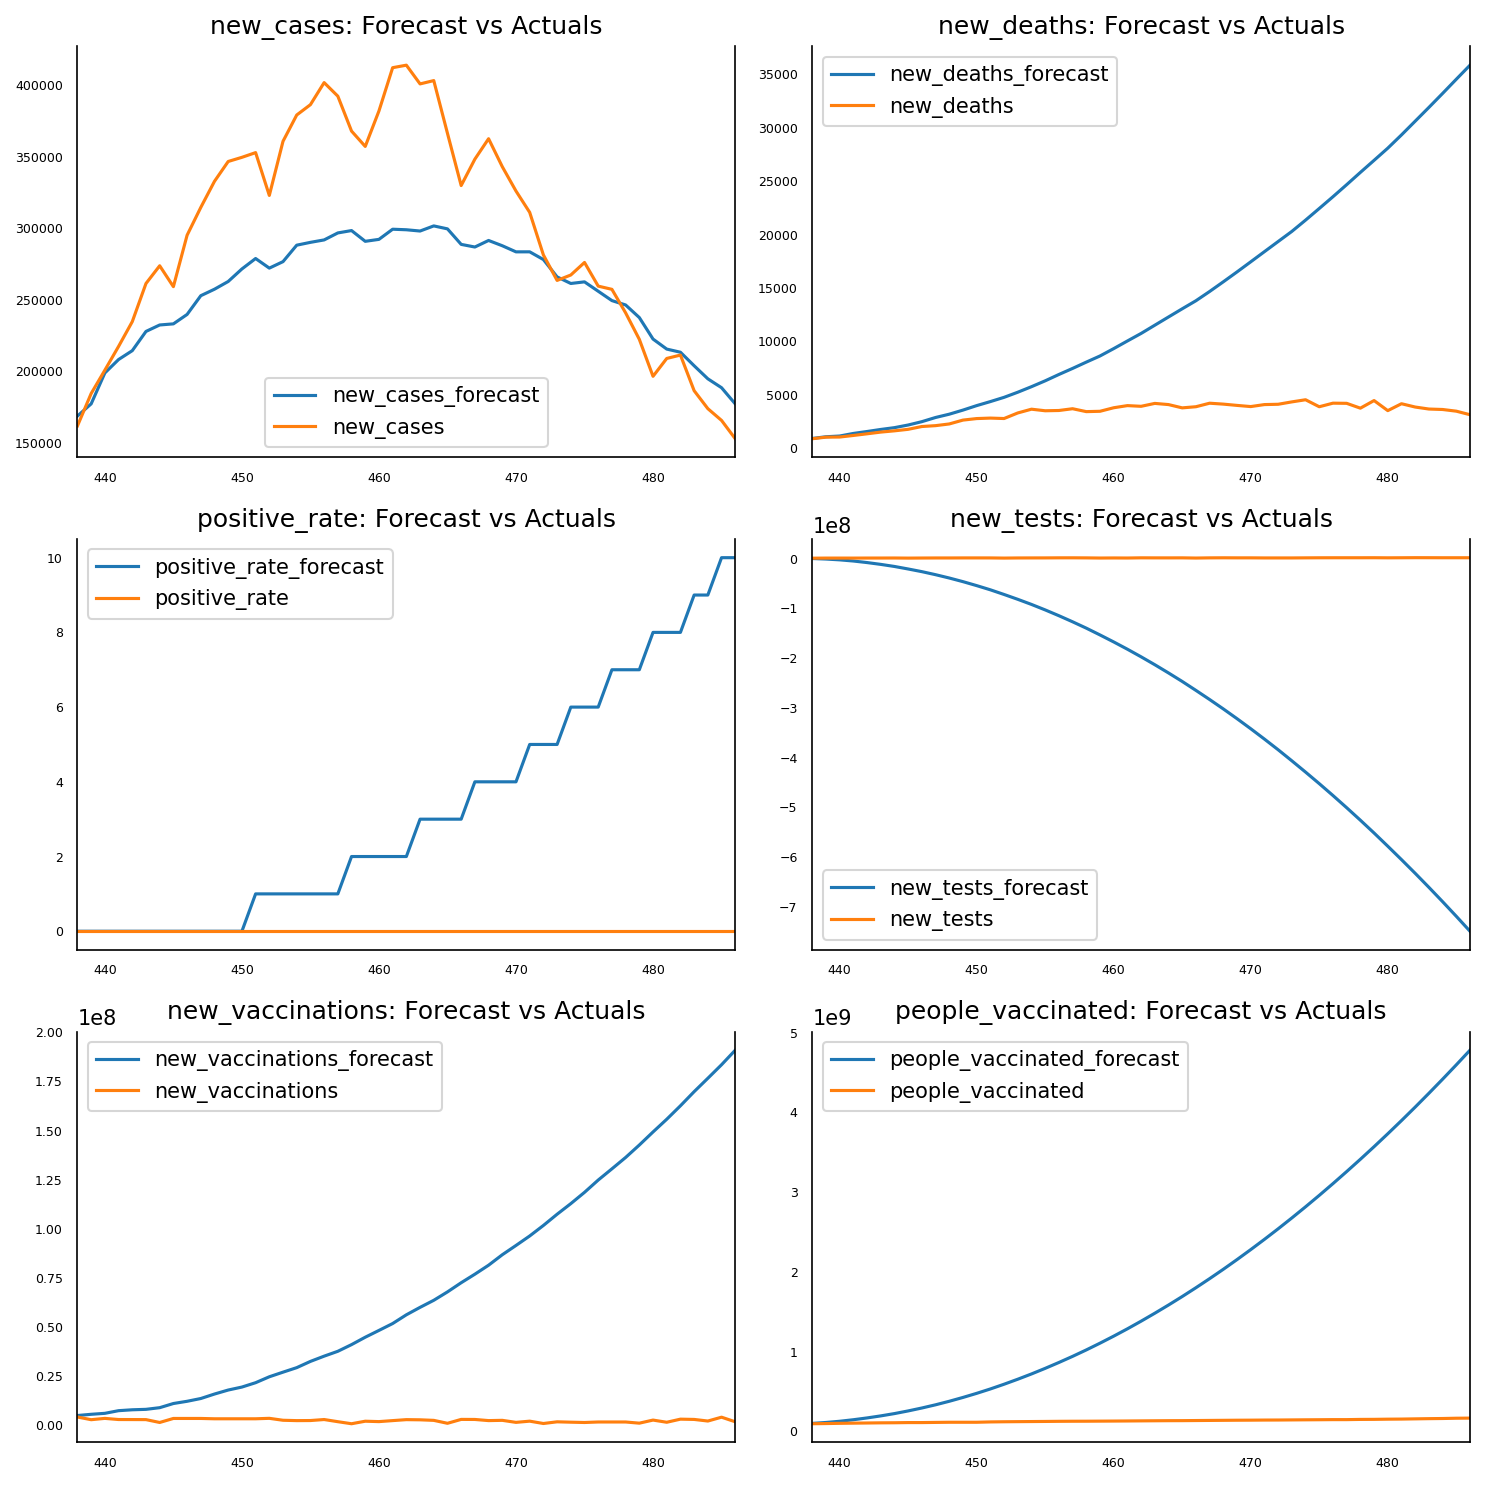

In [ ]:
fig, axes = plt.subplots(nrows=int(len(dataset_cases.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset_cases.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})



In [ ]:
print('Forecast Accuracy of: new_cases')
accuracy_prod = forecast_accuracy(df_results['new_cases_forecast'].values, df_test['new_cases'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


print('Forecast Accuracy of: new_deaths')
accuracy_prod = forecast_accuracy(df_results['new_deaths_forecast'].values, df_test['new_deaths'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

    
print('Forecast Accuracy of: new_tests')
accuracy_prod = forecast_accuracy(df_results['new_tests_forecast'].values, df_test['new_tests'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('Forecast Accuracy of: new_vaccinations')
accuracy_prod = forecast_accuracy(df_results['new_vaccinations_forecast'].values, df_test['new_vaccinations'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


print('Forecast Accuracy of: people_vaccinated')
accuracy_prod = forecast_accuracy(df_results['people_vaccinated_forecast'].values, df_test['people_vaccinated'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: new_cases
mape   :  0.1414
me     :  -40940.4286
mae    :  47077.7755
mpe    :  -0.1076
rmse   :  59260.5657
corr   :  0.9391
minmax :  0.1398
Forecast Accuracy of: new_deaths
mape   :  2.6833
me     :  10155.4082
mae    :  10155.4082
mpe    :  2.6833
rmse   :  14191.3773
corr   :  0.653
minmax :  0.559
Forecast Accuracy of: new_tests
mape   :  135.7652
me     :  -260579164.6327
mae    :  260579164.6327
mpe    :  -135.7652
rmse   :  346254291.3533
corr   :  -0.8069
minmax :  135.7652
Forecast Accuracy of: new_vaccinations
mape   :  41.069
me     :  68020410.7551
mae    :  68020410.7551
mpe    :  41.069
rmse   :  88592029.5049
corr   :  -0.3724
minmax :  0.8836
Forecast Accuracy of: people_vaccinated
mape   :  11.1977
me     :  1618893026.102
mae    :  1618893026.102
mpe    :  11.1977
rmse   :  903157419.5567
corr   :  0.9641
minmax :  0.7959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':


In [ ]:
date_train = df_dates[0:-nobs]
print(date_train.head())
print(date_train.shape)

        date
0 2020-01-30
1 2020-01-31
2 2020-02-01
3 2020-02-02
4 2020-02-03
(438, 1)


In [ ]:
df_train= pd.concat([date_train, df_train], axis=1, join='inner')

In [ ]:
df_train.head()

,new_cases,new_deaths,positive_rate,new_tests,new_vaccinations,people_vaccinated
date,,,,,,
2020-01-30,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-02,1.0,0.0,0.0,0.0,0.0,0.0
2020-02-03,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train.set_index('date', inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 438 entries, 2020-01-30 to 2021-04-11
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   new_cases          438 non-null    float64
 1   new_deaths         438 non-null    float64
 2   positive_rate      438 non-null    float64
 3   new_tests          438 non-null    float64
 4   new_vaccinations   438 non-null    float64
 5   people_vaccinated  438 non-null    float64
dtypes: float64(6)
memory usage: 24.0 KB


In [ ]:
date_test = df_dates[-nobs:]
df_test= pd.concat([date_test, df_test], axis=1, join='inner')
df_test.set_index('date', inplace=True)
df_test.head()

,new_cases,new_deaths,positive_rate,new_tests,new_vaccinations,people_vaccinated
date,,,,,,
2021-04-12,161736,879,0,1180136,4004520,95043039
2021-04-13,184372,1027,0,1400122,2646493,97301914
2021-04-14,200739,1038,0,1411758,3313660,100179199
2021-04-15,217353,1185,0,1384549,2730271,102349255
2021-04-16,234692,1341,0,1473210,2714132,104408484


In [ ]:
date_test = df_dates[-nobs:]
df_results= pd.concat([date_test, df_results], axis=1, join='inner')
df_results.set_index('date', inplace=True)
df_results.head()

,new_cases_3d,new_deaths_3d,positive_rate_3d,new_tests_3d,new_vaccinations_3d,people_vaccinated_3d,new_cases_2d,new_cases_1d,new_cases_forecast,new_deaths_2d,new_deaths_1d,new_deaths_forecast,positive_rate_2d,positive_rate_1d,positive_rate_forecast,new_tests_2d,new_tests_1d,new_tests_forecast,new_vaccinations_2d,new_vaccinations_1d,new_vaccinations_forecast,people_vaccinated_2d,people_vaccinated_1d,people_vaccinated_forecast
date,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-12,-23804,-110,0,-906534,2648737,1925668,-16309,-276,168635,-65,0,903,0,0,0,-1097520,-858692,553354,2427826,1841257,4774675,5047777,7749216,99336616
2021-04-13,25102,228,0,878890,-3647841,-1287812,8793,8516,177152,162,161,1064,0,0,0,-218629,-1077322,-523967,-1220015,621241,5395917,3759964,11509181,110845797
2021-04-14,4315,-254,0,-332700,1090492,-218552,13108,21625,198777,-92,69,1133,0,0,0,-551330,-1628652,-2152620,-129522,491719,5887636,3541411,15050593,125896390
2021-04-15,-25334,263,0,-155787,990282,743724,-12225,9399,208177,170,240,1374,0,0,0,-707117,-2335770,-4488391,860759,1352479,7240115,4285136,19335729,145232120
2021-04-16,9031,-228,0,-87513,-1757525,-1067596,-3194,6204,214382,-57,182,1556,0,0,0,-794631,-3130402,-7618793,-896765,455713,7695829,3217540,22553270,167785390


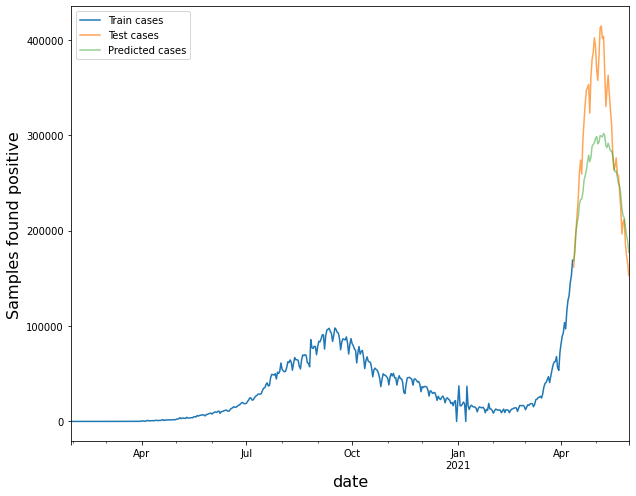

In [ ]:
fig=df_train['new_cases'].plot(label = 'Train cases',legend = True,figsize=(10,8))
fig.set_xlabel('Year', fontsize = 16)
fig.set_ylabel('Samples found positive', fontsize = 16)
df_test['new_cases'].plot(ax=fig,label = 'Test cases',legend = True,alpha=.7,figsize=(10,8))
df_results['new_cases_forecast'].plot(ax=fig,label = 'Predicted cases',legend = True,alpha=.5,figsize=(10,8))
plt.show()
#df_train['new_cases'].plot( legend = True)

In [ ]:
fig, axes = plt.subplots(nrows=int(len(dataset_cases.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset_cases.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(,legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();